In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [3]:
def load_data(dir_list, image_size):
    
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            
            image = cv2.imread(directory + '\\' + filename)
            
            image = crop_brain_contour(image, plot=False)
            
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [4]:
augmented_path = 'augmented data/'

augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [6]:
def split_data(X, y, test_size=0.2):
       
   
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [13]:
def build_model(input_shape):
    
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:

filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/10
1445/1445 [==============================] - 434s 300ms/step - loss: 0.8331 - acc: 0.5945 - val_loss: 0.6829 - val_acc: 0.4968
Epoch 2/10
1445/1445 [==============================] - 463s 320ms/step - loss: 0.4817 - acc: 0.7668 - val_loss: 0.6342 - val_acc: 0.6742
Epoch 3/10
1445/1445 [==============================] - 471s 326ms/step - loss: 0.4361 - acc: 0.8069 - val_loss: 0.5294 - val_acc: 0.8065
Epoch 4/10
1445/1445 [==============================] - 465s 322ms/step - loss: 0.3641 - acc: 0.8574 - val_loss: 0.6092 - val_acc: 0.6323
Epoch 5/10
1445/1445 [==============================] - 457s 316ms/step - loss: 0.3940 - acc: 0.8339 - val_loss: 0.4689 - val_acc: 0.7742
Epoch 6/10
1445/1445 [==============================] - 452s 313ms/step - loss: 0.3154 - acc: 0.8692 - val_loss: 0.4448 - val_acc: 0.7806
Epoch 7/10
1445/1445 [==============================] - 465s 322ms/step - loss: 0.2776 - acc: 0.8872 - val_loss: 0.4747 - val

In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 431s 299ms/step - loss: 0.2065 - acc: 0.9239 - val_loss: 0.3357 - val_acc: 0.8871
Epoch 2/3
1445/1445 [==============================] - 432s 299ms/step - loss: 0.1811 - acc: 0.9363 - val_loss: 0.3529 - val_acc: 0.8516
Epoch 3/3
1445/1445 [==============================] - 425s 294ms/step - loss: 0.1827 - acc: 0.9287 - val_loss: 0.4038 - val_acc: 0.8323
Elapsed time: 0:21:29.4


In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 438s 303ms/step - loss: 0.1471 - acc: 0.9612 - val_loss: 0.3190 - val_acc: 0.8903
Epoch 2/3
1445/1445 [==============================] - 432s 299ms/step - loss: 0.1384 - acc: 0.9564 - val_loss: 0.3509 - val_acc: 0.8613
Epoch 3/3
1445/1445 [==============================] - 429s 297ms/step - loss: 0.1240 - acc: 0.9647 - val_loss: 0.3358 - val_acc: 0.8710
Elapsed time: 0:21:38.5


In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 536s 371ms/step - loss: 0.1586 - acc: 0.9453 - val_loss: 0.4005 - val_acc: 0.8548
Epoch 2/3
1445/1445 [==============================] - 427s 296ms/step - loss: 0.1244 - acc: 0.9647 - val_loss: 0.3149 - val_acc: 0.9000
Epoch 3/3
1445/1445 [==============================] - 429s 297ms/step - loss: 0.1074 - acc: 0.9668 - val_loss: 0.3118 - val_acc: 0.8935
Elapsed time: 0:23:11.9


In [39]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/5
1445/1445 [==============================] - 427s 296ms/step - loss: 0.0899 - acc: 0.9785 - val_loss: 0.3310 - val_acc: 0.8935
Epoch 2/5
1445/1445 [==============================] - 426s 295ms/step - loss: 0.1343 - acc: 0.9509 - val_loss: 0.5169 - val_acc: 0.8258
Epoch 3/5
1445/1445 [==============================] - 425s 294ms/step - loss: 0.1137 - acc: 0.9626 - val_loss: 0.6945 - val_acc: 0.7516
Epoch 4/5
1445/1445 [==============================] - 430s 298ms/step - loss: 0.1018 - acc: 0.9640 - val_loss: 0.3210 - val_acc: 0.9065
Epoch 5/5
1445/1445 [==============================] - 434s 300ms/step - loss: 0.0949 - acc: 0.9689 - val_loss: 0.4250 - val_acc: 0.8484
Elapsed time: 0:35:41.9


In [21]:
history = model.history.history

In [22]:
for key in history.keys():
    print(key)

val_loss
val_acc
loss
acc


In [23]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

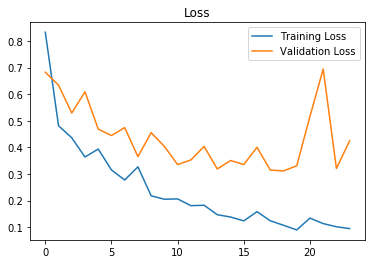

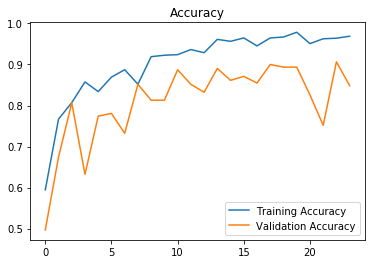

In [68]:
plot_metrics(history) 

In [11]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [12]:
best_model.metrics_names

['loss', 'acc']

In [13]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 32s 103ms/sample - loss: 0.1183 - acc: 0.9742


In [14]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.1183303304737614
Test Accuracy = 0.9741935729980469


In [15]:
y_test_prob = best_model.predict(X_test)

In [16]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9729729729729729


In [17]:
y_val_prob = best_model.predict(X_val)

In [18]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.960725075528701


In [19]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_val, y_val_prob)

In [20]:
roc_auc = metrics.auc(fpr, tpr)

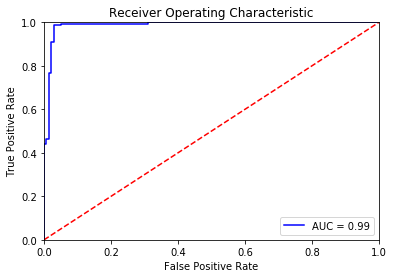

In [21]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [24]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
cm_plot_labels = ['no','yes']

In [29]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

This is where I am stuck while generating confusion matrix, I am sure I have made a silly mistake which I can't figure out. Please help.

In [27]:

cm = confusion_matrix(y_test, y_test_prob)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')